# <u>Submission instructions</u>
### Submission in pairs unless otherwise authorized
<ul style="font-size: 17px">
<li> This notebook contains all the questions. You should follow the instructions below.</li>
<li> Solutions for both theoretical and practical parts should be written in this notebook</li>
</ul>

<h3> Moodle submission</h3>


<p style="font-size: 17px">
You should submit three files:
</p>
<ul style="font-size: 17px">
<li>IPYNB notebook:
  <ul>
  <li>All the wet and dry parts, including code, graphs, discussion, etc.</li>
  </ul>
</li>
<li>PDF file:
  <ul>
  <li>Export the notebook to PDF. Make sure that all the cells are visible.</li>
  </ul>
</li>
</ul>
<p style="font-size: 17px">
All files should be in the following format: "HW2_ID1_ID2.file"
<br>
Good Luck!
</p>

# Question 1 - Generalizrtion and Overfit (30 pt)

<p style="font-size: 17px"> In this exercise, we will demonstrate overfitting to random labels.The settings are the following:
<ul style="font-size: 17px">
<li> Use the MNIST dataset.
<li> Work on the first 128 samples from the training dataset.
<li> Fix the following parameters:
    <ul>
        <li> Shuffle to False.
        <li> Batch size to 128.
    </ul>
<li> Generate random labels from Bernoulli distribution with a probability of $\frac{1}{2}$. I.e.,each sample is assigned a random label which is zero or one.
</ul>

<p style="font-size: 17px">
Show that by using a Fully Connected netwrok and cross-entropy loss, you are able to achieve a loss value of ~0 (the lower the better).
Plot the accuracy and loss convergence for this data and the test data as a function of epochs.
What is the accuracy value of the test data? Explain
</p>

Epoch [1/100] Train Loss: 0.6916 | Train Acc: 53.12% Test Loss: 0.7183 | Test Acc: 49.28%
Epoch [2/100] Train Loss: 0.6208 | Train Acc: 67.19% Test Loss: 0.7373 | Test Acc: 50.03%
Epoch [3/100] Train Loss: 0.5798 | Train Acc: 69.53% Test Loss: 0.7705 | Test Acc: 49.78%
Epoch [4/100] Train Loss: 0.5460 | Train Acc: 73.44% Test Loss: 0.7832 | Test Acc: 50.21%
Epoch [5/100] Train Loss: 0.5136 | Train Acc: 76.56% Test Loss: 0.7903 | Test Acc: 49.67%
Epoch [6/100] Train Loss: 0.4842 | Train Acc: 78.91% Test Loss: 0.8026 | Test Acc: 49.70%
Epoch [7/100] Train Loss: 0.4550 | Train Acc: 80.47% Test Loss: 0.8148 | Test Acc: 49.70%
Epoch [8/100] Train Loss: 0.4273 | Train Acc: 83.59% Test Loss: 0.8208 | Test Acc: 49.61%
Epoch [9/100] Train Loss: 0.4005 | Train Acc: 83.59% Test Loss: 0.8331 | Test Acc: 49.87%
Epoch [10/100] Train Loss: 0.3751 | Train Acc: 87.50% Test Loss: 0.8531 | Test Acc: 49.77%
Epoch [11/100] Train Loss: 0.3518 | Train Acc: 89.84% Test Loss: 0.8716 | Test Acc: 50.12%
Epoch [1

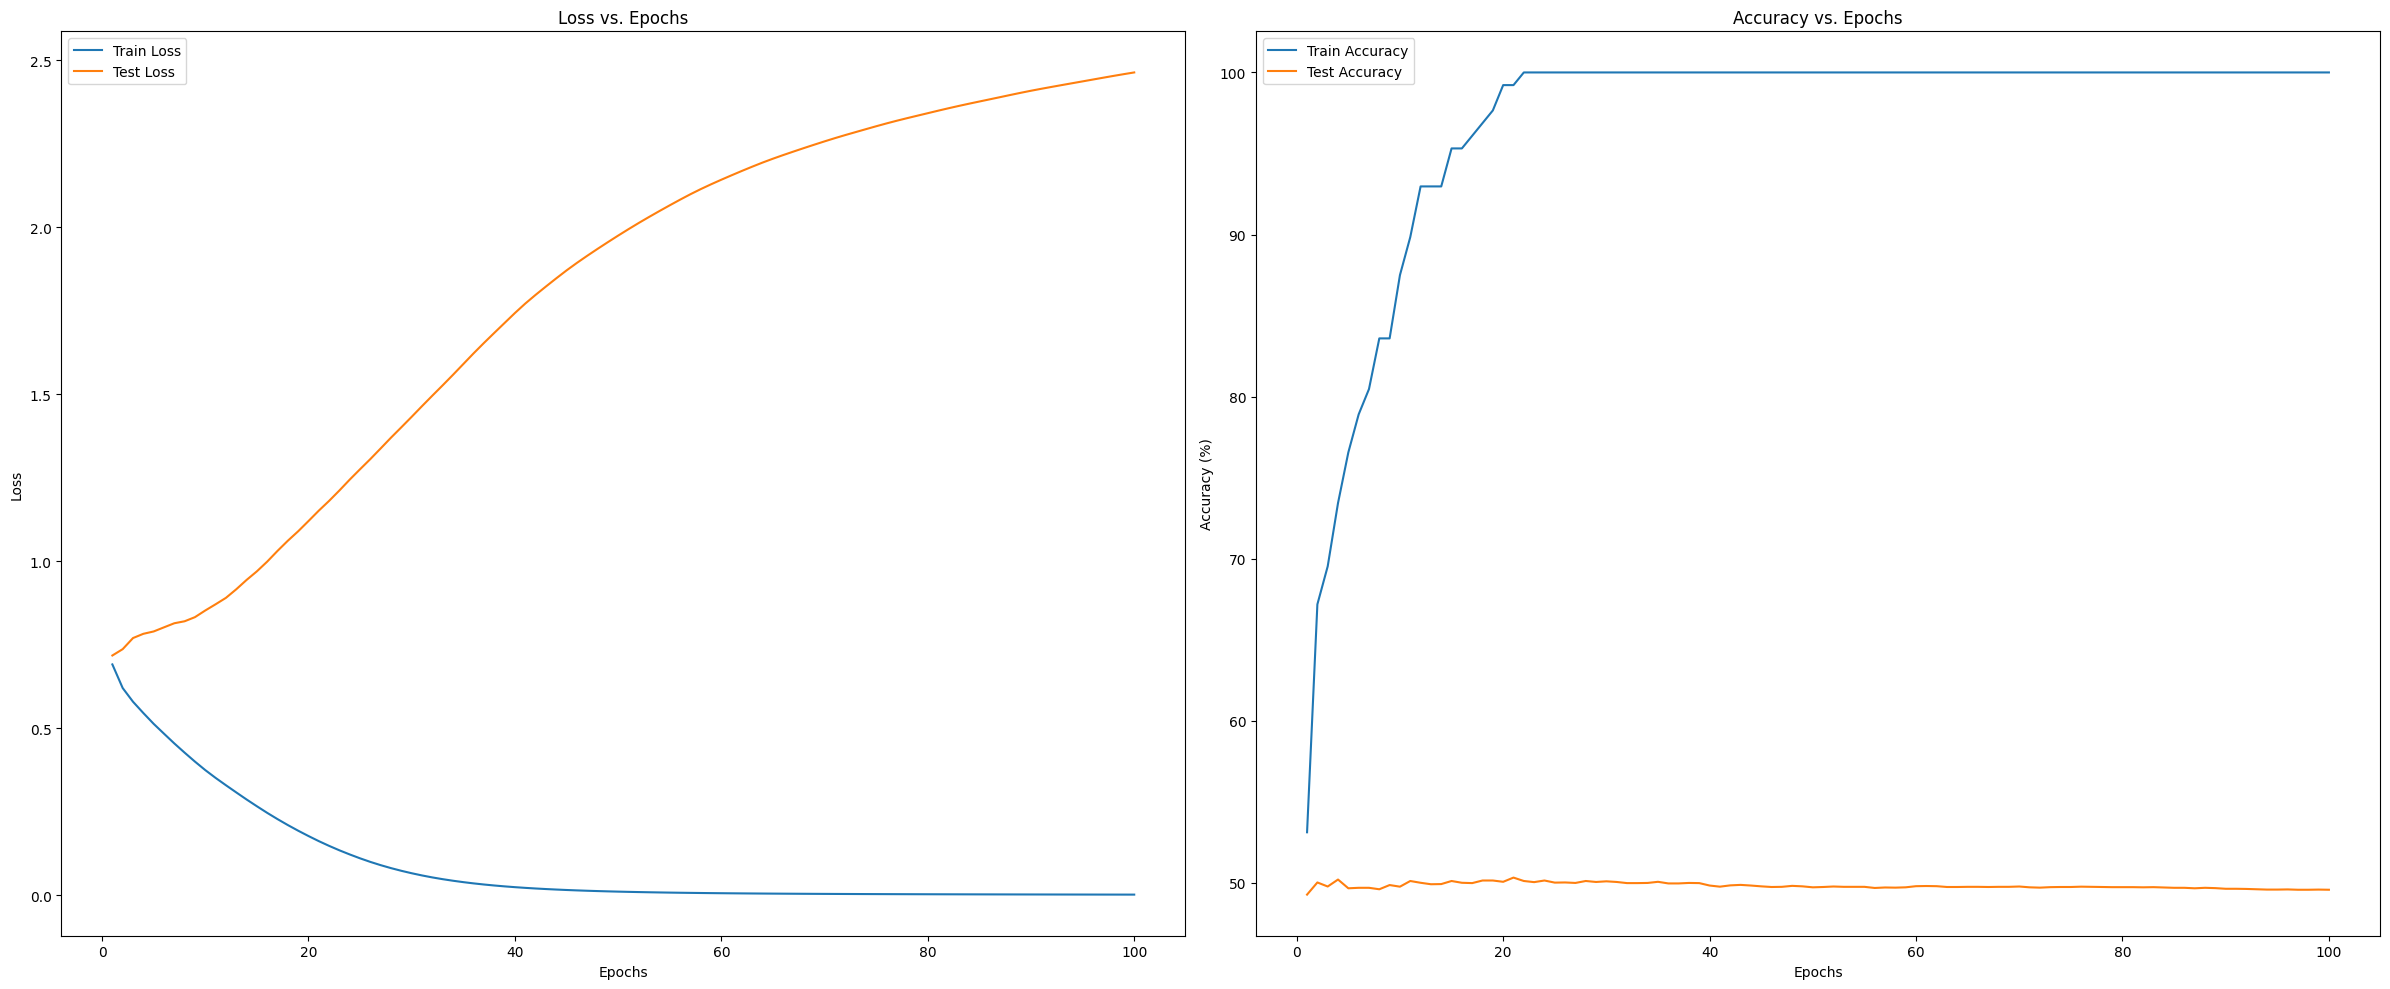

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------------------------------
# 1) Load the MNIST dataset
# -----------------------------------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform
)

# We only use the first 128 samples from the training set
subset_indices = list(range(128))
train_subset = Subset(train_dataset, subset_indices)

# -----------------------------------------------------
# 2) Assign random binary labels to these 128 samples
#    and to the entire test set
# -----------------------------------------------------
# Training subset random labels
random_labels_train = torch.bernoulli(0.5 * torch.ones(128)).long()
train_subset.targets = random_labels_train

# Test set random labels (for ALL test samples)
random_labels_test = torch.bernoulli(0.5 * torch.ones(len(test_dataset))).long()
test_dataset.targets = random_labels_test

# -----------------------------------------------------
# 3) Create DataLoaders with shuffle=False for train,
#    and standard for test (shuffle=False is fine too).
# -----------------------------------------------------
train_loader = DataLoader(
    train_subset,
    batch_size=128,
    shuffle=False  # as requested
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1024,
    shuffle=False
)

# -----------------------------------------------------
# 4) Define a simple fully-connected network
#    (From 784 -> 128 -> 2)
# -----------------------------------------------------
class SimpleFCNet(nn.Module):
    def __init__(self):
        super(SimpleFCNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 2)  # For 2-class output

    def forward(self, x):
        x = x.view(x.size(0), -1)  # flatten 28x28 into 784
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleFCNet()

# -----------------------------------------------------
# 5) Define loss function and optimizer
# -----------------------------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# -----------------------------------------------------
# 6) Training loop
# -----------------------------------------------------
num_epochs = 100
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    ###################################
    # Training on random-labeled data
    ###################################
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, _ in train_loader:
        labels = train_subset.targets

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        # Compute training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    epoch_loss = running_loss / total_train
    epoch_acc = 100.0 * correct_train / total_train
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    ###################################
    # Testing on random-labeled data
    ###################################

    model.eval()
    running_test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        # Each mini-batch (images, original_label) but original_label is ignored
        for images, _ in test_loader:

            batch_size = images.size(0)
            labels = random_labels_test[:batch_size]

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)

    epoch_test_loss = running_test_loss / total_test
    epoch_test_acc = 100.0 * correct_test / total_test
    test_losses.append(epoch_test_loss)
    test_accuracies.append(epoch_test_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.2f}% "
          f"Test Loss: {epoch_test_loss:.4f} | Test Acc: {epoch_test_acc:.2f}%")

# -----------------------------------------------------
# 7) Plot the accuracy and loss for train & test
# -----------------------------------------------------
epochs_range = range(1, num_epochs+1)

plt.figure(figsize=(24, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs. Epochs')
plt.legend()

plt.tight_layout()
plt.show()


From the 100th epoch, the test accuracy is about 49.58%. This is equivalent to a random-chance performance for a 2-class prediction. We will try to explain this phenomenon :

The training labels were assigned randomly (Bernoulli(1/2)). The model learned to memorize these 128 random labels, minimizing the training loss to near zero.
Because there is no real correlation between the MNIST images and those random labels we generated, the model learned parameters that do not generalize to the real test images.
As a result, the accuracy on test data is around 50%, just about expected performance when randomly assigning a label in a 2-class classification task.

********************

<h1> Question 2 - Sentiment Analysis - Classification (70 pt)</h1>

### Exercise
<p style="font-size: 17px">
The goal of this exercise is to get familiar with recurrent neural networks.
<br><br>
The field of detecting which emotion is represented in a text is developing and being
studied due to its usefulness. For example, detecting if a review is positive or
negative and more.
<br><br>
In this exercise, you will detect the emotion of a sentence. You should get at least 47% accuracy on the test set.
<br><br>
You should
<ul style="font-size: 17px">
  <li> Try different model architectures - Vanilla RNN and Gated model (GRU/LSTM)</li>
  <li> Use different optimization and regularization methods </li>
  <li> Try different combinations of hyperparamters</li>
</ul>
</p>

<br>

### Data

<p style="font-size: 17px">
The data is a csv file containing tweets and their labels according to the emotion –
{happiness, sadness, neutral}. Every row in the file (except for the header) is an
example.
<br>
Examples: (Notepad++ view)
<ul style="font-size: 17px">
  <li> happiness,Welcome @doeko ! Really glad to know you here. Your products rox man</li>
  <li> sadness,Disappointment really sucks! I'm getting used to it.</li>
  <li> neutral,I just want to Sleep.</li>
</ul>
<p style="font-size: 17px">
You have a train file – "trainEmotions.csv" and a test file – "testEmotions.csv". Both files can be found in the "HW2_data.zip" file.
</p>

### Tips

<p style="font-size: 17px">
Instead of using One-hot embeddings for the data, use <code>nn.Embedding</code>.
You also might add "Start Of Sentence" (SOS) and "End Of Sentence" (EOS) embeddings.
</p>

### a) EDA (10 pt)

<p style="font-size: 17px">
Explore and analyze your data. Explain your data cleaning and processing pipeline.
</p>

*****************************

In [ ]:
import pandas as pd

test_path = r"/content/testEmotions.csv"
train_path = r"/content/trainEmotions.csv"

test_data = pd.read_csv(test_path)
train_data = pd.read_csv(train_path)

In [ ]:
print("Train Data:")
print(train_data.head())
print("\nTest Data:")
print(test_data.head())

Train Data:
     emotion                                            content
0  happiness  victory for the bulldogs was celebrated by 3 w...
1  happiness                     @saraLDS Thanks for that, Sara
2  happiness  @Tony_Mandarich well welcome back from the dar...
3  happiness            @sai_shediddy lol , you gotta share too
4  happiness  first up, make up for lost time with jelly. Ja...

Test Data:
     emotion                                            content
0  happiness  @pkollar very heart-warming indeed. I'll be lo...
1  happiness  @kellieann1 haha hi mum! wow yes, very modern ...
2  happiness  Always thinking about to look for a good place...
3  happiness  Early lunch then getting all dressed up for Am...
4  happiness  hi @blowmefool thanks for the follow  good luc...


In [ ]:
print("\nTrain Data Shape:", train_data.shape)
print("Test Data Shape:", test_data.shape)


Train Data Shape: (14504, 2)
Test Data Shape: (4837, 2)


In [ ]:
print("\nTrain Data Distribution:")
print(train_data['emotion'].value_counts())
print("\nTest Data Distribution:")
print(test_data['emotion'].value_counts())


Train Data Distribution:
emotion
happiness    5430
neutral      5182
sadness      3892
Name: count, dtype: int64

Test Data Distribution:
emotion
happiness    1811
neutral      1728
sadness      1298
Name: count, dtype: int64


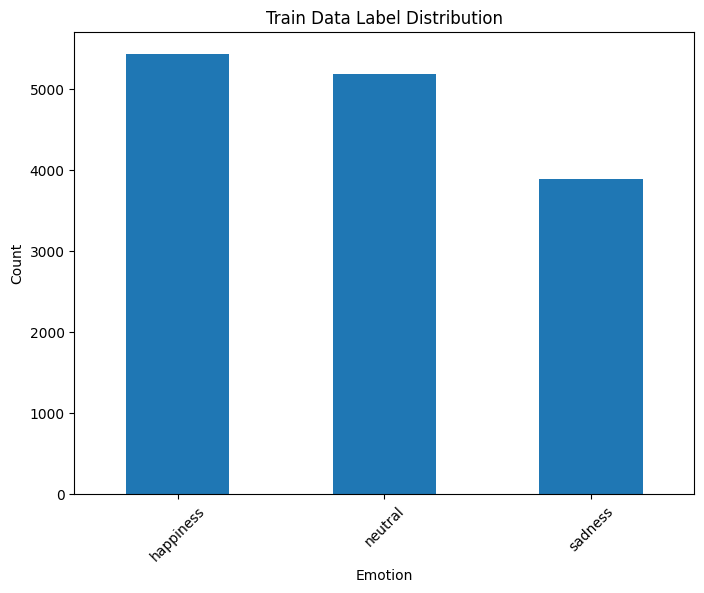

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
train_data['emotion'].value_counts().plot(kind='bar')
plt.title('Train Data Label Distribution')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [ ]:
import re
# Remove duplications from the train and test datasets
train_data = train_data.drop_duplicates(subset=['content'])
test_data = test_data.drop_duplicates(subset=['content'])

# remove special characters from text
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)
train_data['content'] = train_data['content'].apply(remove_punctuation)
test_data['content'] = test_data['content'].apply(remove_punctuation)

<ipython-input-6-2c1d9fb1827f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['content'] = train_data['content'].apply(remove_punctuation)


### b) Main (50 pt)

<p style="font-size: 17px">
Define 2 models, as requested. Train and eval them.
<ul style="font-size: 17px">
<li> Plot the gated model's accuracy and loss (both on train and test sets) as a function of the epochs.
<li> Plot a confusion matrix
</ul>

</p>

In [ ]:
!pip install gensim


In [ ]:
import gensim.downloader as downloader
print("Gensim imported successfully!")


Gensim imported successfully!


In [ ]:
import gensim.downloader as downloader
import numpy as np

#download the word embedding model
word2vec_model = downloader.load('word2vec-google-news-300')

#applly the word embedding to the dara, if not in model use zero vector as word embedding
def preprocess(text):
    tokens = text.split()
    embeddings = [word2vec_model[token] for token in tokens if token in word2vec_model.key_to_index]
    if not embeddings:
        embeddings = [np.zeros(word2vec_model.vector_size)]
    return embeddings

train_data['embeddings'] = train_data['content'].apply(preprocess)
test_data['embeddings'] = test_data['content'].apply(preprocess)

train_data.loc[:, 'embeddings'] = train_data['content'].apply(preprocess)
test_data.loc[:, 'embeddings'] = test_data['content'].apply(preprocess)

[==================================================] 100.0% 1662.8/1662.8MB downloaded


*****************************


--- GRU: hidden=128, dropout=0.1, lr=0.001, layers=1, optimizer=adam ---
Epoch [1/5] Train Loss: 0.9902 | Train Acc: 0.4583 | Test Loss: 1.2209 | Test Acc: 0.4288
Epoch [2/5] Train Loss: 0.8110 | Train Acc: 0.6359 | Test Loss: 1.1427 | Test Acc: 0.4564
Epoch [3/5] Train Loss: 0.7532 | Train Acc: 0.6747 | Test Loss: 1.0867 | Test Acc: 0.5317
Epoch [4/5] Train Loss: 0.7277 | Train Acc: 0.6867 | Test Loss: 1.1796 | Test Acc: 0.5120
Epoch [5/5] Train Loss: 0.6992 | Train Acc: 0.7022 | Test Loss: 1.0638 | Test Acc: 0.5414

--- LSTM: hidden=128, dropout=0.1, lr=0.001, layers=1, optimizer=adam ---
Epoch [1/5] Train Loss: 1.0575 | Train Acc: 0.4115 | Test Loss: 1.0765 | Test Acc: 0.4046
Epoch [2/5] Train Loss: 0.9187 | Train Acc: 0.5164 | Test Loss: 1.1147 | Test Acc: 0.4671
Epoch [3/5] Train Loss: 0.8812 | Train Acc: 0.5611 | Test Loss: 1.1556 | Test Acc: 0.4472
Epoch [4/5] Train Loss: 0.9617 | Train Acc: 0.5112 | Test Loss: 1.0923 | Test Acc: 0.4717
Epoch [5/5] Train Loss: 0.8983 | Train Ac

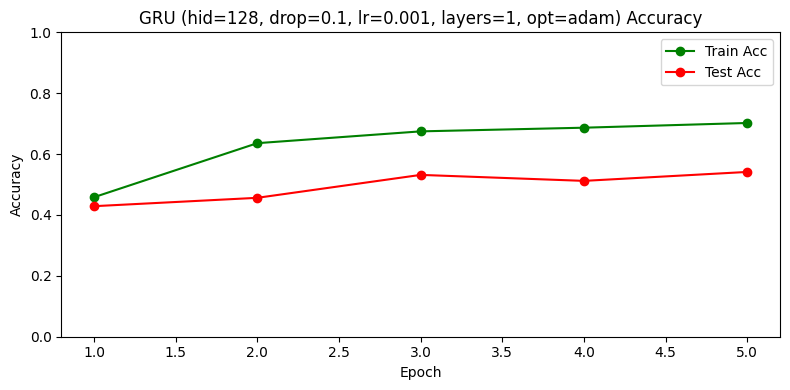

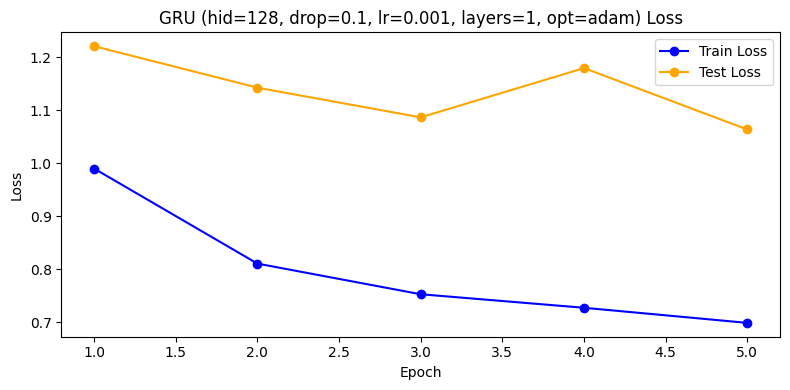

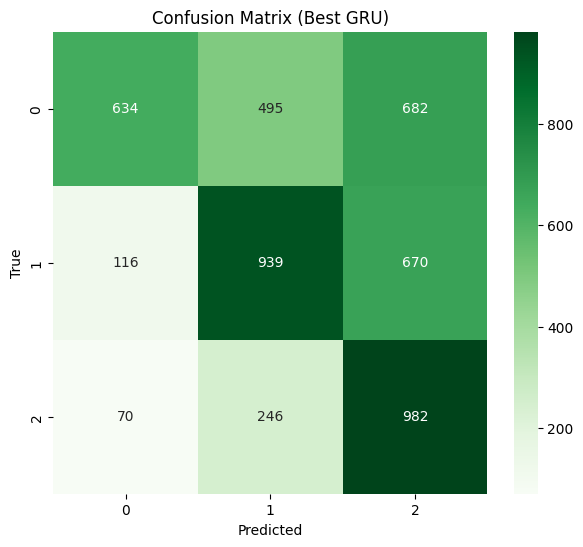


Best LSTM experiment hyperparams: {'hidden_dim': 128, 'dropout': 0.5, 'lr': 0.001, 'num_layers': 1, 'optimizer': 'adam', 'train_losses': [1.029095607784997, 0.9138420850566004, 0.865934346827258, 0.8320986093145556, 0.7932895459564386], 'train_accs': [0.43287405663643286, 0.5492626185695493, 0.5988368067575989, 0.6291629162916291, 0.6581735096586582], 'test_losses': [1.0770227018939822, 1.1272339646361376, 1.0559851433101453, 1.0849882472110421, 1.084401328704859], 'test_accs': [0.4240794373189905, 0.42449317335539927, 0.5246172941663219, 0.5204799338022342, 0.5221348779478693]}


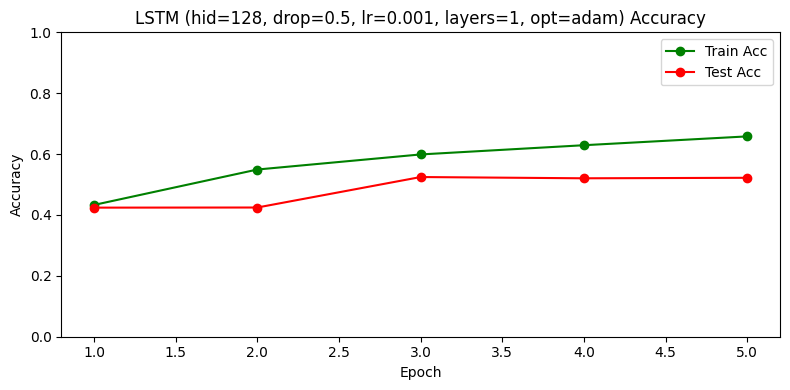

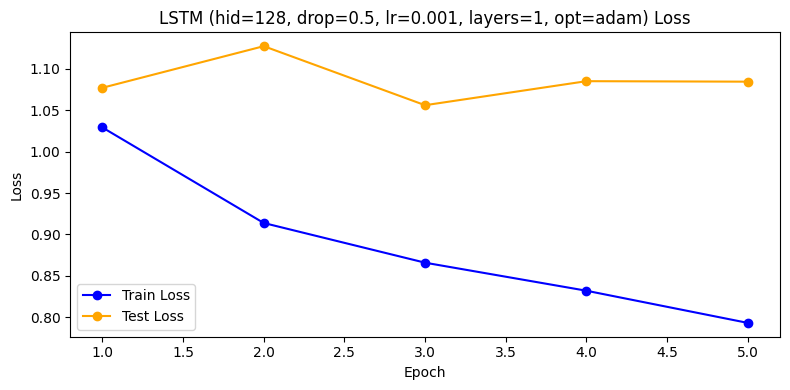

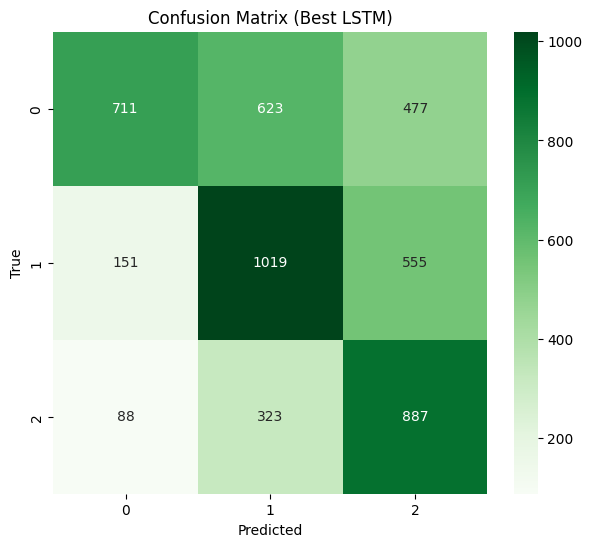

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import gensim.downloader as api
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import LabelEncoder

# ==========================
#   1) Model Definitions
# ==========================

class GRUModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, num_layers=1, dropout_rate=0.5):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers,
                          batch_first=True, dropout=(dropout_rate if num_layers > 1 else 0.0))
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, hidden = self.gru(x)
        dropped = self.dropout(hidden[-1])
        out = self.fc(dropped)
        return out


class LSTMModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, num_layers=1, dropout_rate=0.5):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=(dropout_rate if num_layers > 1 else 0.0))
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        dropped = self.dropout(hidden[-1])
        out = self.fc(dropped)
        return out

# ==========================
#   2) Training Function
# ==========================

def train_and_evaluate_model(model,
                             train_loader,
                             test_loader,
                             criterion,
                             optimizer,
                             num_epochs=10,
                             verbose=True):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device).float()
            labels = labels.to(device).long()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

        # Collect training stats
        train_loss_epoch = train_loss / len(train_loader)
        train_acc_epoch = train_correct / train_total
        train_losses.append(train_loss_epoch)
        train_accuracies.append(train_acc_epoch)

        # Evaluate on test set
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device).float()
                labels = labels.to(device).long()

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                test_correct += (predicted == labels).sum().item()
                test_total += labels.size(0)

        test_loss_epoch = test_loss / len(test_loader)
        test_acc_epoch = test_correct / test_total
        test_losses.append(test_loss_epoch)
        test_accuracies.append(test_acc_epoch)

        if verbose:
            print(f'Epoch [{epoch+1}/{num_epochs}] '
                  f'Train Loss: {train_loss_epoch:.4f} | Train Acc: {train_acc_epoch:.4f} '
                  f'| Test Loss: {test_loss_epoch:.4f} | Test Acc: {test_acc_epoch:.4f}')

    return train_losses, train_accuracies, test_losses, test_accuracies


# ==========================
#   3) Data Preparation
# ==========================


train_embeddings = [torch.FloatTensor(x) for x in train_data['embeddings']]
test_embeddings  = [torch.FloatTensor(x) for x in test_data['embeddings']]

# Pad variable-length sequences
train_inputs = pad_sequence(train_embeddings, batch_first=True, padding_value=0.0)
test_inputs  = pad_sequence(test_embeddings, batch_first=True, padding_value=0.0)

# Label encoding
le = LabelEncoder()
train_data['emotion'] = le.fit_transform(train_data['emotion'])
test_data['emotion']  = le.transform(test_data['emotion'])

train_labels = torch.tensor(train_data['emotion'].values)
test_labels  = torch.tensor(test_data['emotion'].values)

# Create data loaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(list(zip(train_inputs, train_labels)),
                                           batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(list(zip(test_inputs, test_labels)),
                                           batch_size=batch_size)

num_classes = len(le.classes_)
embedding_dim = train_inputs.shape[-1]


# ===================================
#   4) Hyperparameter Experiments
# ===================================

hidden_dims = [128, 256]
dropout_rates = [0.1, 0.5]
learning_rates = [0.001, 0.0001]
num_layers = 1
optimizers_to_test = ['adam', 'sgd']

results = {
    'GRU': [],
    'LSTM': []
}

criterion = nn.CrossEntropyLoss()
NUM_EPOCHS = 5

for hidden_dim in hidden_dims:
    for dropout in dropout_rates:
        for lr in learning_rates:
            for opt_name in optimizers_to_test:

                print(f"\n--- GRU: hidden={hidden_dim}, dropout={dropout}, lr={lr}, "
                      f"layers={num_layers}, optimizer={opt_name} ---")

                # ---------- GRU Experiment ----------
                gru_model = GRUModel(
                    embedding_dim=embedding_dim,
                    hidden_dim=hidden_dim,
                    output_dim=num_classes,
                    num_layers=num_layers,
                    dropout_rate=dropout
                )
                if opt_name == 'adam':
                    optimizer_gru = optim.Adam(gru_model.parameters(), lr=lr)
                else:
                    optimizer_gru = optim.SGD(gru_model.parameters(), lr=lr, momentum=0.9)

                gru_train_losses, gru_train_accs, gru_test_losses, gru_test_accs = train_and_evaluate_model(
                    model=gru_model,
                    train_loader=train_loader,
                    test_loader=test_loader,
                    criterion=criterion,
                    optimizer=optimizer_gru,
                    num_epochs=NUM_EPOCHS,
                    verbose=True
                )

                results['GRU'].append({
                    'hidden_dim': hidden_dim,
                    'dropout': dropout,
                    'lr': lr,
                    'num_layers': num_layers,  # We keep track even if it's fixed
                    'optimizer': opt_name,
                    'train_losses': gru_train_losses,
                    'train_accs': gru_train_accs,
                    'test_losses': gru_test_losses,
                    'test_accs': gru_test_accs
                })

                print(f"\n--- LSTM: hidden={hidden_dim}, dropout={dropout}, lr={lr}, "
                      f"layers={num_layers}, optimizer={opt_name} ---")

                # ---------- LSTM Experiment ----------
                lstm_model = LSTMModel(
                    embedding_dim=embedding_dim,
                    hidden_dim=hidden_dim,
                    output_dim=num_classes,
                    num_layers=num_layers,
                    dropout_rate=dropout
                )
                if opt_name == 'adam':
                    optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=lr)
                else:
                    optimizer_lstm = optim.SGD(lstm_model.parameters(), lr=lr, momentum=0.9)

                lstm_train_losses, lstm_train_accs, lstm_test_losses, lstm_test_accs = train_and_evaluate_model(
                    model=lstm_model,
                    train_loader=train_loader,
                    test_loader=test_loader,
                    criterion=criterion,
                    optimizer=optimizer_lstm,
                    num_epochs=NUM_EPOCHS,
                    verbose=True
                )

                results['LSTM'].append({
                    'hidden_dim': hidden_dim,
                    'dropout': dropout,
                    'lr': lr,
                    'num_layers': num_layers,  # We keep track even if it's fixed
                    'optimizer': opt_name,
                    'train_losses': lstm_train_losses,
                    'train_accs': lstm_train_accs,
                    'test_losses': lstm_test_losses,
                    'test_accs': lstm_test_accs
                })


# ========================================
#   5) Plotting / Comparing Experiments
# ========================================

def plot_best_experiment(model_name, best_exp):
    """
    Plots only train/test accuracy and train/test loss for the best experiment.
    """
    train_accs   = best_exp['train_accs']
    test_accs    = best_exp['test_accs']
    train_losses = best_exp['train_losses']
    test_losses  = best_exp['test_losses']
    epochs       = range(1, len(train_accs) + 1)

    label_str = (
        f"{model_name} (hid={best_exp['hidden_dim']}, drop={best_exp['dropout']}, "
        f"lr={best_exp['lr']}, layers={best_exp['num_layers']}, opt={best_exp['optimizer']})"
    )

    # Plot Accuracy
    plt.figure(figsize=(8,4))
    plt.plot(epochs, train_accs, label='Train Acc', color='green', marker='o')
    plt.plot(epochs, test_accs,  label='Test Acc',  color='red',   marker='o')
    plt.title(f'{label_str} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot Loss
    plt.figure(figsize=(8,4))
    plt.plot(epochs, train_losses, label='Train Loss', color='blue',  marker='o')
    plt.plot(epochs, test_losses,  label='Test Loss',  color='orange',marker='o')
    plt.title(f'{label_str} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()


# ==========================
#   6) Confusion Matrices
# ==========================

def get_predictions(model, data_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    all_preds = []
    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device).float()
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
    return all_preds


def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, cmap='Greens', fmt='g',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()


# ==========================================
#   7) Select & Plot Only the Best Results
# ==========================================

# 1) Find best GRU
best_gru_exp = max(results['GRU'], key=lambda x: x['test_accs'][-1])
print("\nBest GRU experiment hyperparams:", best_gru_exp)

# Plot best GRU experiment
plot_best_experiment('GRU', best_gru_exp)

# Rebuild & re-train best GRU model with best config
best_gru_model = GRUModel(
    embedding_dim=embedding_dim,
    hidden_dim=best_gru_exp['hidden_dim'],
    output_dim=num_classes,
    num_layers=best_gru_exp['num_layers'],
    dropout_rate=best_gru_exp['dropout']
)
if best_gru_exp['optimizer'] == 'adam':
    optimizer_retrain_gru = optim.Adam(best_gru_model.parameters(), lr=best_gru_exp['lr'])
else:
    optimizer_retrain_gru = optim.SGD(best_gru_model.parameters(), lr=best_gru_exp['lr'], momentum=0.9)

_ = train_and_evaluate_model(
    model=best_gru_model,
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer_retrain_gru,
    num_epochs=NUM_EPOCHS,
    verbose=False
)

# Get predictions & plot confusion matrix for best GRU
gru_preds = get_predictions(best_gru_model, test_loader)
plot_confusion_matrix(
    y_true=test_labels.numpy(),
    y_pred=gru_preds,
    classes=le.classes_,
    title='Confusion Matrix (Best GRU)'
)


# 2) Find best LSTM
best_lstm_exp = max(results['LSTM'], key=lambda x: x['test_accs'][-1])
print("\nBest LSTM experiment hyperparams:", best_lstm_exp)

# Plot best LSTM experiment
plot_best_experiment('LSTM', best_lstm_exp)

# Rebuild & re-train best_lstm model with best config
best_lstm_model = LSTMModel(
    embedding_dim=embedding_dim,
    hidden_dim=best_lstm_exp['hidden_dim'],
    output_dim=num_classes,
    num_layers=best_lstm_exp['num_layers'],
    dropout_rate=best_lstm_exp['dropout']
)
if best_lstm_exp['optimizer'] == 'adam':
    optimizer_retrain_lstm = optim.Adam(best_lstm_model.parameters(), lr=best_lstm_exp['lr'])
else:
    optimizer_retrain_lstm = optim.SGD(best_lstm_model.parameters(), lr=best_lstm_exp['lr'], momentum=0.9)

_ = train_and_evaluate_model(
    model=best_lstm_model,
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer_retrain_lstm,
    num_epochs=NUM_EPOCHS,
    verbose=False
)

# Get predictions & plot confusion matrix for best LSTM
lstm_preds = get_predictions(best_lstm_model, test_loader)
plot_confusion_matrix(
    y_true=test_labels.numpy(),
    y_pred=lstm_preds,
    classes=le.classes_,
    title='Confusion Matrix (Best LSTM)'
)


### c) Discussion (10 pt)
<p style="font-size: 17px">
Discuss the differences in the methods you have tried.
</p>

*****************************

Through experimenting with the model architecture and hyperparameters, we concluded that different architectural choices, training procedures, and optimization algorithms significantly impact overall model performance.

The phenomenons we noticed are :

- Adam + LR=0.001 often strikes the best balance, yielding consistent improvements in just 5 epochs.

- At small learning rates (like we chose : 0.001 or 0.0001), SGD often stagnates prematurely unless supplemented with techniques like momentum, extended training epochs, or a learning rate schedule. Especially when the dropout is high (0.5 in our experiments), we noticed that the loss values doe stagnate with SGD optimizer.

- Increasing hidden size (128 → 256) adds capacity but may only show modest gains in a short training run like we did (for simplicity concerns of results).

- Moderate dropout (0.1) gives a decent generalization boost. But we think that heavy dropout (0.5) requires more epochs or a larger dataset to show if it is relevant. We had the feeling that it leads the model to underfit (poor performances on both train and test)

It seems to us that SGD is a simple optimizer but requires tuning of learning rates while offering strong theoretical guarantees that we saw in nonlinear models course. Adam adapts learning rates automatically, generally converges quickly with minimal setup, but can overfit quickly.

Finding the right combination of hyperparameters such as learning rate, hidden dimension, batch size, dropout rate, or optimizer type is not tractable due to the sheer number of possible permutations. A typical brute-force or grid search approach quickly becomes computationally expensive, especially as the model grows or the dataset becomes larger. Each new parameter and each additional value in the search space multiplies the total combinations that must be tested.

Overall, we think that a balanced strategy combining theoretical knowledge about hyperparameter behaviors with practical heuristics is crucial to efficiently navigate the vast hyperparameter space. This informed approach saves computational resources and shortens the experimental cycle, ultimately leading to better models in less time.

In conclusion, this exercise demonstrates how tuning hyperparameters can significantly influence model performance and reveals how these hyperparameters interact between them.